## TrainingPhase和General调度程序
创建一个调度程序，使您可以使用以下不同的TrainingPhase训练模型。

### class TrainingPhase
`TrainingPhase(length:int)`

为长度迭代阶段安排超参数。

然后，您可以使用以下方法计划所需的任何超参数。

<b>schedule_hp</b>

`schedule_hp(name, vals, anneal=None)`

使用退火在val之间添加名称计划。

在退火之后，该阶段将使超参数从val中的第一个值变化到第二个值。 如果指定退火函数但是vals是浮点数，它将衰减为0.如果没有指定退火函数，则默认值为元组的线性退火，如果是浮点数则为常量参数。

`注意：如果要使用判别式值，可以在`vals`中传递一个numpy数组（或者它们的元组用于启动和停止）。`

基本的超参数命名为：

* 'lr'用于学习率
* 'mom'的动力（或Adam的beta1）
* 'beta' Adam的β2或者RMSprop的alpha
* 'wd'用于梯度衰减

您还可以添加优化器中的任何超参数（即使它是自定义的或GeneralOptimizer），如果您使用的是Adam，也可以添加'eps'。

让我们用一个例子来编写带有热重启的SGD。

In [1]:
def fit_sgd_warm(learn, n_cycles, lr, mom, cycle_len, cycle_mult):
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n * (cycle_len * cycle_mult**i))
                 .schedule_hp('lr', lr, anneal=annealing_cos)
                 .schedule_hp('mom', mom)) for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    if cycle_mult != 1:
        total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: total_epochs = n_cycles * cycle_len
    learn.fit(total_epochs)

In [2]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
fit_sgd_warm(learn, 3, 1e-3, 0.9, 1, 2)

epoch,train_loss,valid_loss,accuracy,time
0,0.169713,0.157265,0.944553,01:07
1,0.128610,0.122057,0.956330,01:03
2,0.117595,0.115338,0.957802,01:05
3,0.098058,0.093810,0.963690,01:00
4,0.091226,0.084315,0.969087,00:59
5,0.080955,0.078853,0.972522,00:59
6,0.073230,0.076501,0.972522,00:59


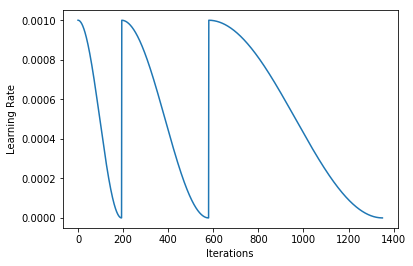

In [4]:
learn.recorder.plot_lr()

### class GeneralScheduler
`GeneralScheduler(learn:Learner, phases:Collection[TrainingPhase], start_epoch:int=None) :: LearnerCallback`

为学习者安排多个TrainingPhase。

### Callback methods
你不要自己调用 - 他们会被fastai的Callback系统自动调用，以启用该类的功能。

<b>on_batch_end</b>

`on_batch_end(train, **kwargs:Any)`

在当前阶段迈出一步，为下一批准备超参数。

<b>on_train_begin</b>

`on_train_begin(epoch:int, **kwargs:Any)`

启动超参数到第一阶段的起始值。